In [1]:
import igraph as ig#version 0.10.4 returned Node with 17916 
import cairo
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df_info = pd.read_csv('Model_Dataset.csv')
df_info = df_info.fillna(0)
df_info.head()

,Unnamed: 0,Provider,PotentialFraud,In_weight_count_Degree,In_weight_count_Betweenness,In_weight_count_Closeness,In_weight_reimburse_Degree,In_weight_reimburse_Betweenness,In_weight_reimburse_Closeness,In_weight_physician_Degree,...,Out_BeneCount,Out_InscClaimAmtReimbursed,Out_NumberOfPhysician,Out_ClmDiagnosisCode_Count,Out_ClmProcedureCode_Count,Full_BeneCount,Full_InscClaimAmtReimbursed,Full_NumberOfPhysician,Full_ClmDiagnosisCode_Count,Full_ClmProcedureCode_Count
0,0,PRV51001,No,7.000,0.000,0.159,236500.000,0.000,0.159,13.500,...,20.000,382.000,1.600,2.200,0.000,25,4185.600,1.600,3.200,0.120
1,1,PRV51003,Yes,26.000,0.002,0.163,196233.340,0.002,0.163,41.320,...,70.000,466.714,1.429,2.714,0.000,132,4588.409,1.530,5.250,0.364
2,2,PRV51004,No,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,149.000,350.134,1.604,2.584,0.000,149,350.134,1.604,2.584,0.000
3,3,PRV51005,Yes,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1165.000,241.124,1.599,2.589,0.000,1165,241.124,1.599,2.589,0.000
4,4,PRV51007,No,3.000,0.000,0.158,17166.660,0.000,0.158,4.160,...,69.000,213.188,1.536,2.797,0.000,72,468.194,1.528,2.986,0.014


In [3]:
def categorise(row):  
    if row['PotentialFraud'] == 'Yes':
        return 1
    return 0
df_info['PotentialFraudDecider'] = df_info.apply(lambda row: categorise(row), axis=1)

In [4]:
col_select = {}
count = 0
for col in df_info.columns:
    if not col in ['Provider','PotentialFraud','PotentialFraudDecider','Unnamed: 0']:
        #print(col)        
        subset = df_info[['PotentialFraudDecider',col]]
        subset = subset.loc[~subset[col].isna()]
        #print(subset['PotentialFraudDecider'].corr(subset[col]))
        col_select[col] = subset['PotentialFraudDecider'].corr(subset[col])
        count +=1 

In [5]:
df_col = pd.DataFrame.from_dict(col_select, orient='index', columns=['Correlation']).rename_axis('Columns').reset_index().sort_values(by='Correlation',ascending=False)

### 1.0 Define training attributes and label attribute

In [6]:
training_attr = [
    'In_weight_count_Degree','In_weight_count_Betweenness','In_weight_count_Closeness',
    'In_weight_reimburse_Degree','In_weight_reimburse_Betweenness','In_weight_reimburse_Closeness',
    'In_weight_physician_Degree','In_weight_physician_Betweenness','In_weight_physician_Closeness',
    'In_weight_diagnosis_Degree','In_weight_diagnosis_Betweenness','In_weight_diagnosis_Closeness',
    'In_weight_procedure_Degree','In_weight_procedure_Betweenness','In_weight_procedure_Closeness',
    'Out_weight_count_Degree','Out_weight_count_Betweenness','Out_weight_count_Closeness',
    'Out_weight_reimburse_Degree','Out_weight_reimburse_Betweenness','Out_weight_reimburse_Closeness',
    'Out_weight_physician_Degree','Out_weight_physician_Betweenness','Out_weight_physician_Closeness',
    'Out_weight_diagnosis_Degree','Out_weight_diagnosis_Betweenness','Out_weight_diagnosis_Closeness',
    'Out_weight_procedure_Degree','Out_weight_procedure_Betweenness','Out_weight_procedure_Closeness',
    'Full_weight_count_Degree','Full_weight_count_Betweenness','Full_weight_count_Closeness',
    'Full_weight_reimburse_Degree','Full_weight_reimburse_Betweenness','Full_weight_reimburse_Closeness',
    'Full_weight_physician_Degree','Full_weight_physician_Betweenness','Full_weight_physician_Closeness',
    'Full_weight_diagnosis_Degree','Full_weight_diagnosis_Betweenness','Full_weight_diagnosis_Closeness',
    'Full_weight_procedure_Degree','Full_weight_procedure_Betweenness','Full_weight_procedure_Closeness',
    'In_weight_count_Degree_dist','In_weight_count_Betweenness_dist','In_weight_count_Closeness_dist',
    'In_weight_reimburse_Degree_dist','In_weight_reimburse_Betweenness_dist','In_weight_reimburse_Closeness_dist',
    'In_weight_physician_Degree_dist','In_weight_physician_Betweenness_dist','In_weight_physician_Closeness_dist',
    'In_weight_diagnosis_Degree_dist','In_weight_diagnosis_Betweenness_dist','In_weight_diagnosis_Closeness_dist',
    'In_weight_procedure_Degree_dist','In_weight_procedure_Betweenness_dist','In_weight_procedure_Closeness_dist',
    'Out_weight_count_Degree_dist','Out_weight_count_Betweenness_dist','Out_weight_count_Closeness_dist',
    'Out_weight_reimburse_Degree_dist','Out_weight_reimburse_Betweenness_dist','Out_weight_reimburse_Closeness_dist',
    'Out_weight_physician_Degree_dist','Out_weight_physician_Betweenness_dist','Out_weight_physician_Closeness_dist',
    'Out_weight_diagnosis_Degree_dist','Out_weight_diagnosis_Betweenness_dist','Out_weight_diagnosis_Closeness_dist',
    'Out_weight_procedure_Degree_dist','Out_weight_procedure_Betweenness_dist','Out_weight_procedure_Closeness_dist',
    'Full_weight_count_Degree_dist','Full_weight_count_Betweenness_dist','Full_weight_count_Closeness_dist',
    'Full_weight_reimburse_Degree_dist','Full_weight_reimburse_Betweenness_dist','Full_weight_reimburse_Closeness_dist',
    'Full_weight_physician_Degree_dist','Full_weight_physician_Betweenness_dist','Full_weight_physician_Closeness_dist',
    'Full_weight_diagnosis_Degree_dist','Full_weight_diagnosis_Betweenness_dist','Full_weight_diagnosis_Closeness_dist',
    'Full_weight_procedure_Degree_dist','Full_weight_procedure_Betweenness_dist','Full_weight_procedure_Closeness_dist',
    'In_BeneCount','In_InscClaimAmtReimbursed','In_NumberOfPhysician','In_ClmDiagnosisCode_Count','In_ClmProcedureCode_Count',
    'Out_BeneCount','Out_InscClaimAmtReimbursed',#'Out_NumberOfPhysician','Out_ClmDiagnosisCode_Count',
    'Out_ClmProcedureCode_Count',
    'Full_BeneCount','Full_InscClaimAmtReimbursed','Full_NumberOfPhysician','Full_ClmDiagnosisCode_Count','Full_ClmProcedureCode_Count',
]
training_attr = df_col.loc[df_col.Correlation > abs(0.05)].Columns
label_attr = 'PotentialFraudDecider'

In [7]:
X = df_info[training_attr]
y = df_info[label_attr]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_std  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

    
def generate_plot(model, test_data = X_test_std):
    
      
    cm = confusion_matrix(y_test, model.predict(test_data), labels=model.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot();

    positive_class = 1

    probs = model.predict_proba(test_data)[:,positive_class]
    fpr,tpr,thresholds = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)

    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
    plt.plot([0,1],[0,1],'r-.')
    lims = [-0.05,1.05]
    plt.xlim()
    plt.ylim(lims)
    plt.title('Receiver Operating Characteristic\nLogistic Regression')
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.subplot(2,1,2)
    plt.plot(fpr[1:],thresholds[1:],'g--', label='Threshold')
    plt.xlim(lims)
    plt.xlabel('False Positive Rate')
    plt.ylabel('Threshold');
    
    print('Auc Score: ', auc)
    
    positive_class = 1

    probs = model.predict_proba(test_data)[:, positive_class]
    precision,recall,thresholds = precision_recall_curve(y_test, probs)

    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(recall,precision,'b')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title('Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.subplot(2,1,2)
    plt.plot(recall[1:],thresholds,'g--', label='Threshold')
    plt.xlim(lims)
    plt.xlabel('Recall')
    plt.ylabel('Threshold');

    
    return

#### 1.1 Logistic Regression with Imbalanced Data

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
model = LogisticRegression()

In [13]:
model.fit(X_train_std, y_train)

C:\Users\zhizh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [14]:
model.coef_

array([[ 0.8876588 ,  0.5947177 ,  0.86913396,  0.02054606,  0.29001594,
        -0.50163509,  0.4278914 , -0.58630868,  0.52810141, -0.45470253,
        -0.43241257,  0.10626147, -0.89893249,  0.29820592, -0.17358907,
        -0.28204844,  0.03153894,  0.03153894,  0.03153894,  0.03153894,
         0.03153894,  0.03153894,  0.03153894,  0.03153894,  0.03153894,
         0.03153894, -0.28612493,  0.1273376 ,  0.16194646, -0.28254329,
         0.38645778,  0.48080526, -0.36084673,  0.56110209,  0.49802084,
         0.11466199,  0.83453095,  0.07814677,  0.10964938, -0.09890151,
        -0.84156687,  0.27158017,  0.07469319,  0.46618299, -0.03047242,
        -0.03047242,  0.08962799,  0.08962799,  0.00857417,  0.00857417,
        -0.11096218,  0.04100116,  0.04100116,  0.04100116,  0.04100116,
         0.04100116,  0.04100116,  0.04100116,  0.04100116,  0.04100116,
         0.04100116, -0.00151683, -0.00151683,  0.02531712,  0.02531712,
        -0.04994483, -0.04994483,  0.324511  ,  0.3

In [15]:
model.intercept_

array([-3.466691])

In [16]:
model.score(X_train_std, y_train), model.score(X_test_std, y_test)
#0.940234134319162

(0.9368893583311328, 0.940234134319162)

In [17]:
model.classes_

array([0, 1], dtype=int64)

Auc Score:  0.9511163190096248


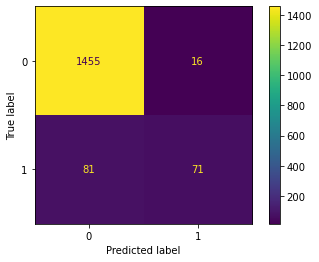

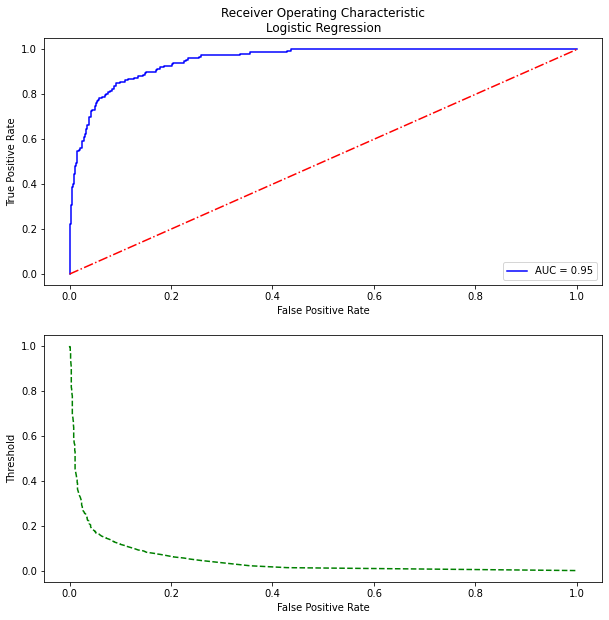

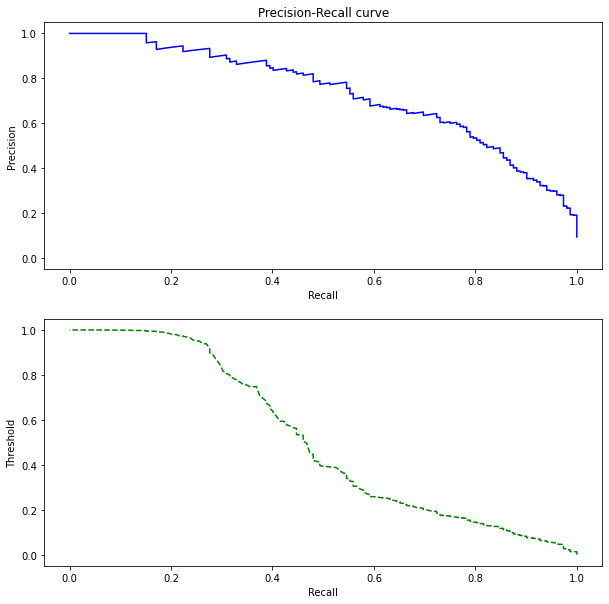

In [18]:
generate_plot(model)

#### Stats

In [19]:
import statsmodels.api as sm

In [20]:
model2 = sm.GLM(y_train.values, sm.add_constant(X_train_std), family=sm.families.Binomial())
result = model2.fit()
result.summary()

C:\Users\zhizh\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\zhizh\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
C:\Users\zhizh\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 3787
Model:                            GLM   Df Residuals:                     3730
Model Family:                Binomial   Df Model:                           56
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 05 Mar 2023   Deviance:                       25881.
Time:                        15:10:41   Pearson chi2:                 1.27e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                  -4.902e+14   1.09e+06  -4.49e+08      0.000    -4.9e+14    -4.9e+14
In_BeneCount                            2.403e+24   2.21e+17   1.09e+07      0.000     2.4e+24     2.4e+24
In_weight_diagnosis_Degree             -7.021e+14    4.8e+07  -1.46e+07      0.000   -7.02e+14   -7.02e+14
In_weight_count_Degree                  1.862e+15   4.93e+07   3.78e+07      0.000    1.86e+15    1.86e+15
In_weight_physician_Degree             -8.243e+14      3e+07  -2.75e+07      0.000   -8.24e+14   -8.24e+14
In_weight_procedure_Degree              2.199e+14   1.34e+07   1.64e+07      0.000     2.2e+14     2.2e+14
In_weight_reimburse_Degree             -1.078e+14   1.12e+07  -9.66e+06      0.000   -1.08e+14   -1.08e+14
Full_weight_procedure_Degree_dist      -7.402e+14   2.34e+07  -3.16e+07      0.000    -7.4e+14    -7.4e+14
Full_weight_procedure_Degree            4.286e+14   2.27e+07   1.89e+07      0.000    4.29e+14    4.29e+14
In_weight_reimburse_Degree_dist         4.919e+14   1.04e+07   4.74e+07      0.000    4.92e+14    4.92e+14
In_weight_physician_Degree_dist         1.596e+13   3.27e+07   4.88e+05      0.000     1.6e+13     1.6e+13
In_weight_diagnosis_Degree_dist          1.44e+14   4.74e+07   3.04e+06      0.000    1.44e+14    1.44e+14
In_weight_procedure_Degree_dist         2.548e+14   1.22e+07   2.08e+07      0.000    2.55e+14    2.55e+14
In_weight_count_Degree_dist            -1.214e+15   5.04e+07  -2.41e+07      0.000   -1.21e+15   -1.21e+15
Full_weight_reimburse_Degree_dist       1.693e+15   3.45e+07    4.9e+07      0.000    1.69e+15    1.69e+15
Full_weight_reimburse_Degree           -2.031e+15   3.62e+07  -5.61e+07      0.000   -2.03e+15   -2.03e+15
Full_weight_diagnosis_Degree_dist      -4.161e+15    2.2e+08  -1.89e+07      0.000   -4.16e+15   -4.16e+15
In_weight_count_Closeness_dist           2.36e+26   2.21e+19   1.07e+07      0.000    2.36e+26    2.36e+26
In_weight_reimburse_Closeness_dist     -3.849e+26   3.45e+19  -1.12e+07      0.000   -3.85e+26   -3.85e+26
In_weight_procedure_Closeness_dist     -3.708e+26   3.38e+19   -1.1e+07      0.000   -3.71e+26   -3.71e+26
In_weight_diagnosis_Closeness_dist      2.524e+26   2.27e+19   1.11e+07      0.000    2.52e+26    2.52e+26
In_weight_physician_Closeness_dist      2.675e+26    2.4e+19   1.12e+07      0.000    2.67e+26    2.67e+26
In_weight_physician_Closeness           2.634e+26   2.35e+19   1.12e+07      0.000    2.63e+26    2.63e+26
In_weight_diagnosis_Closeness           2.483e+26   2.27e+19    1.1e+07      0.000    2.48e+26    2.48e+26
In_weight_count_Closeness              -3.817e+26   3.42e+19  -1.12e+07      0.000   -3.82e+26   -3.82e+26
In_weight_procedure_Closeness          -3.767e+26   3.44e+19  -1.09e+07      0.000   -3

#### 1.2 Logistic Regression with SMOTE applied

In [21]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [22]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 4904, 1: 506})


In [23]:
len(y)

5410

In [24]:
sm = SMOTE(random_state=42)

In [25]:
X_res, y_res = sm.fit_resample(X, y)

In [26]:
print('New dataset shape %s' % Counter(y_res))

New dataset shape Counter({0: 4904, 1: 4904})


In [27]:
len(y_res)

9808

In [28]:
from sklearn.model_selection import train_test_split

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=1)

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std_res = pd.DataFrame(scaler.fit_transform(X_train_res))
X_test_std_res  = pd.DataFrame(scaler.transform(X_test_res))

In [30]:
model_smote = LogisticRegression()

In [31]:
model_smote.fit(X_train_std_res, y_train_res)

C:\Users\zhizh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [32]:
#model_smote.score(X_train_std_res, y_train_res), model_smote.score(X_test_std_res, y_test_res)

In [33]:
model_smote.score(X_train_std, y_train), model_smote.score(X_test_std, y_test)
#0.6715958102279729

C:\Users\zhizh\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\zhizh\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


(0.654607869025614, 0.6715958102279729)

C:\Users\zhizh\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\zhizh\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\zhizh\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Auc Score:  0.9465410211456582


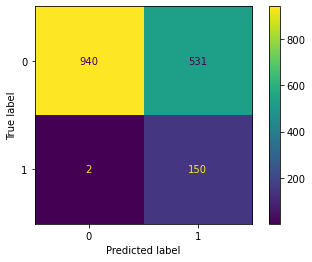

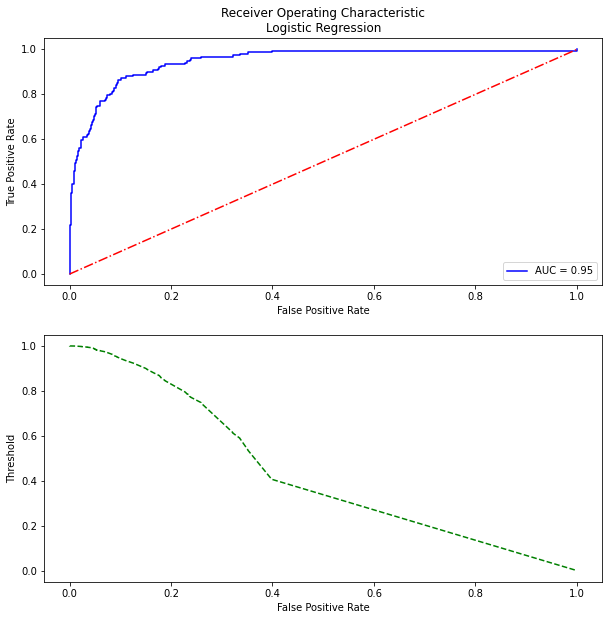

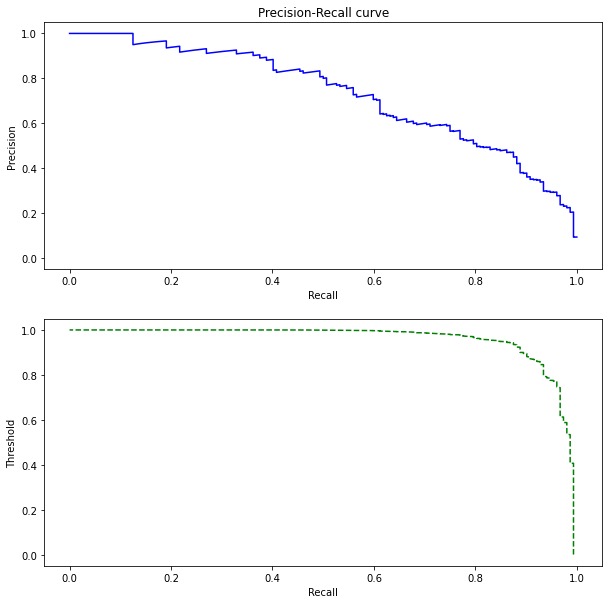

In [34]:
generate_plot(model_smote)

#### 1.3 Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [36]:
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics  
count = 0
best_parameter = ['',0]

while count < 10:
    selected_parameter = []
    selected_parameter.append(random.choice(random_grid['bootstrap']))
    selected_parameter.append(random.choice(random_grid['max_depth']))
    selected_parameter.append(random.choice(random_grid['max_features']))
    selected_parameter.append(random.choice(random_grid['min_samples_leaf']))
    selected_parameter.append(random.choice(random_grid['min_samples_split']))
    selected_parameter.append(random.choice(random_grid['n_estimators']))
    print('bootstrap:', selected_parameter[0],'; max_depth:', selected_parameter[1],'; max_features:', selected_parameter[2],'; min_samples_leaf:', selected_parameter[3],'; min_samples_split:', selected_parameter[4],'; n_estimators:', selected_parameter[5])
    clf = RandomForestClassifier(bootstrap = selected_parameter[0], max_depth = selected_parameter[1], max_features = selected_parameter[2], min_samples_leaf = selected_parameter[3], min_samples_split = selected_parameter[4], n_estimators = selected_parameter[5])
    clf.fit(X_train_std, y_train) 
    y_pred = clf.predict(X_test_std)
    score = metrics.accuracy_score(y_test, y_pred)
    print("ACCURACY OF THE MODEL: ", score)
    if score > best_parameter[1]:
        best_parameter[0] = selected_parameter
        best_parameter[1] = score
    count += 1

bootstrap: True ; max_depth: 80 ; max_features: sqrt ; min_samples_leaf: 1 ; min_samples_split: 5 ; n_estimators: 300
ACCURACY OF THE MODEL:  0.9420825631546519
bootstrap: True ; max_depth: 80 ; max_features: auto ; min_samples_leaf: 4 ; min_samples_split: 2 ; n_estimators: 200
ACCURACY OF THE MODEL:  0.9408502772643254
bootstrap: False ; max_depth: 60 ; max_features: auto ; min_samples_leaf: 1 ; min_samples_split: 2 ; n_estimators: 700
ACCURACY OF THE MODEL:  0.9414664202094886
bootstrap: True ; max_depth: 20 ; max_features: auto ; min_samples_leaf: 2 ; min_samples_split: 2 ; n_estimators: 400
ACCURACY OF THE MODEL:  0.9420825631546519
bootstrap: False ; max_depth: 50 ; max_features: auto ; min_samples_leaf: 2 ; min_samples_split: 2 ; n_estimators: 700
ACCURACY OF THE MODEL:  0.9426987060998152
bootstrap: True ; max_depth: 100 ; max_features: sqrt ; min_samples_leaf: 2 ; min_samples_split: 10 ; n_estimators: 800
ACCURACY OF THE MODEL:  0.940234134319162
bootstrap: False ; max_depth: 1

In [37]:
best_parameter

[[True, 50, 'auto', 1, 5, 800], 0.944547134935305]

In [38]:
clf = RandomForestClassifier(bootstrap = best_parameter[0][0], max_depth = best_parameter[0][1], max_features = best_parameter[0][2], min_samples_leaf = best_parameter[0][3], min_samples_split = best_parameter[0][4], n_estimators = best_parameter[0][5])
clf.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=50, max_features='auto', min_samples_split=5,
                       n_estimators=800)

In [39]:
#clf.score(X_train_std_res, y_train_res), clf.score(X_test_std_res, y_test_res)

In [40]:
clf.score(X_train_std, y_train), clf.score(X_test_std, y_test)
#0.1583487369069624

(0.9976234486400845, 0.9426987060998152)

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = clf.predict(X_test_std)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8105263157894737
Recall: 0.506578947368421
F1 Score: 0.6234817813765182


Auc Score:  0.9424755805216645


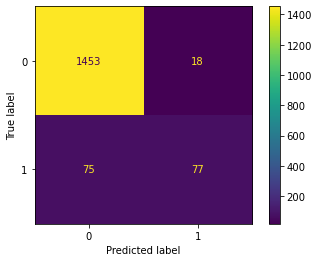

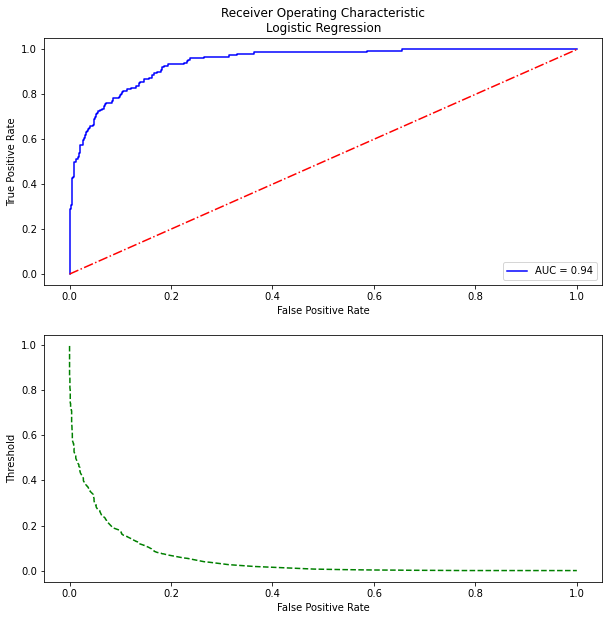

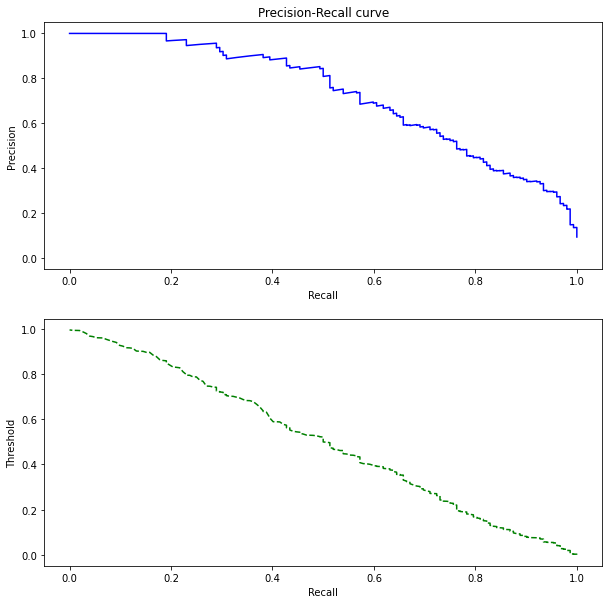

In [42]:
generate_plot(clf)

Columns
In_BeneCount                          0.057
In_weight_physician_Degree            0.040
In_weight_diagnosis_Degree            0.040
In_weight_reimburse_Degree            0.040
In_weight_procedure_Degree            0.035
                                       ... 
Out_weight_procedure_Closeness        0.004
Out_weight_physician_Closeness_dist   0.004
Out_weight_count_Closeness            0.004
Out_weight_procedure_Degree           0.001
Out_weight_procedure_Degree_dist      0.001
Length: 96, dtype: float64


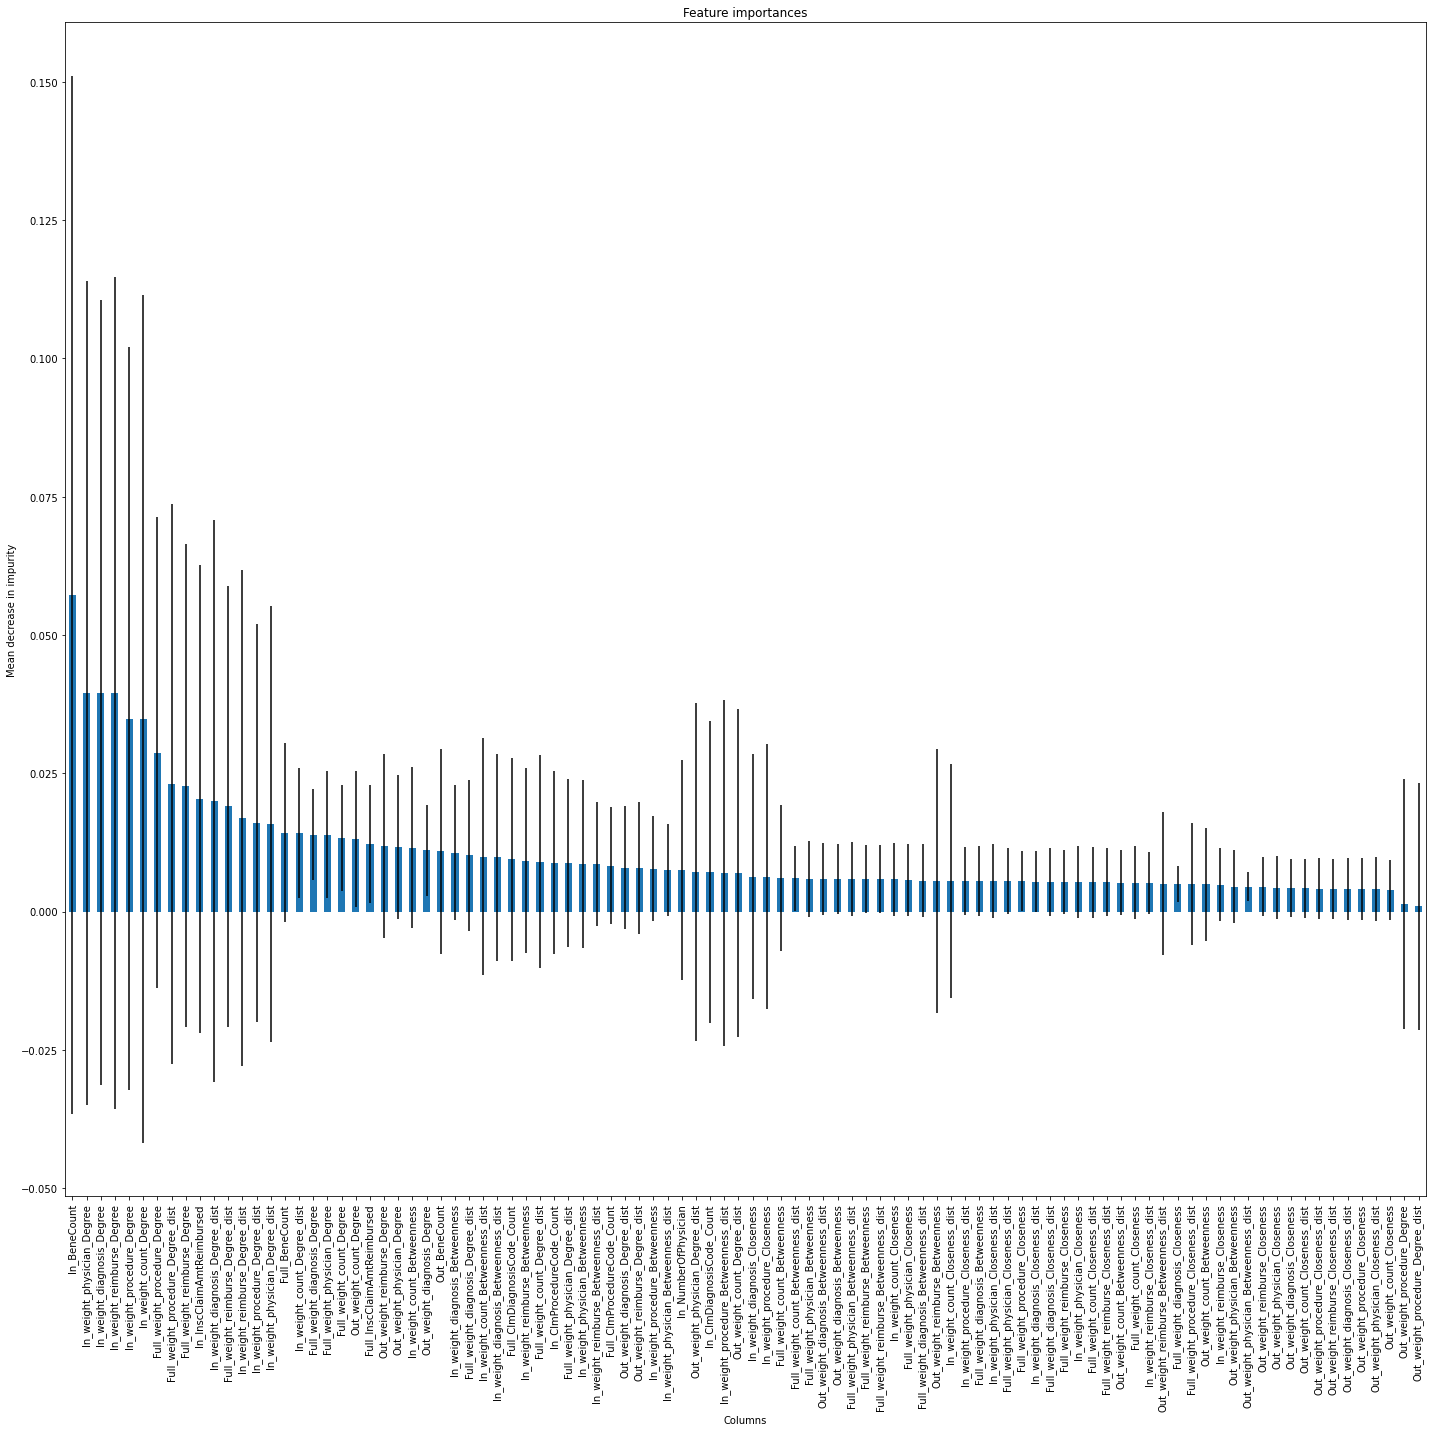

In [43]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=training_attr)
forest_importances = forest_importances.sort_values(ascending=False)
print(forest_importances)

fig, ax = plt.subplots(figsize=(20,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [44]:
X_feature_select = df_info[forest_importances[forest_importances>0.005].index]
y = df_info[label_attr]

In [45]:
from sklearn.model_selection import train_test_split

X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(X_feature_select, y, test_size=0.3, stratify=y, random_state=1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std_select = pd.DataFrame(scaler.fit_transform(X_train_select), columns=X_train_select.columns)
X_test_std_select  = pd.DataFrame(scaler.transform(X_test_select), columns=X_test_select.columns)

In [46]:
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics  
count = 0
best_parameter = ['',0]

while count < 10:
    selected_parameter = []
    selected_parameter.append(random.choice(random_grid['bootstrap']))
    selected_parameter.append(random.choice(random_grid['max_depth']))
    selected_parameter.append(random.choice(random_grid['max_features']))
    selected_parameter.append(random.choice(random_grid['min_samples_leaf']))
    selected_parameter.append(random.choice(random_grid['min_samples_split']))
    selected_parameter.append(random.choice(random_grid['n_estimators']))
    print('bootstrap:', selected_parameter[0],'; max_depth:', selected_parameter[1],'; max_features:', selected_parameter[2],'; min_samples_leaf:', selected_parameter[3],'; min_samples_split:', selected_parameter[4],'; n_estimators:', selected_parameter[5])
    clf = RandomForestClassifier(bootstrap = selected_parameter[0], max_depth = selected_parameter[1], max_features = selected_parameter[2], min_samples_leaf = selected_parameter[3], min_samples_split = selected_parameter[4], n_estimators = selected_parameter[5])
    clf.fit(X_train_std_select, y_train_select) 
    y_pred = clf.predict(X_test_std_select)
    score = metrics.accuracy_score(y_test_select, y_pred)
    print("ACCURACY OF THE MODEL: ", score)
    if score > best_parameter[1]:
        best_parameter[0] = selected_parameter
        best_parameter[1] = score
    count += 1

bootstrap: False ; max_depth: 50 ; max_features: auto ; min_samples_leaf: 2 ; min_samples_split: 10 ; n_estimators: 900
ACCURACY OF THE MODEL:  0.9414664202094886
bootstrap: True ; max_depth: 40 ; max_features: auto ; min_samples_leaf: 2 ; min_samples_split: 10 ; n_estimators: 900
ACCURACY OF THE MODEL:  0.9420825631546519
bootstrap: True ; max_depth: 110 ; max_features: sqrt ; min_samples_leaf: 2 ; min_samples_split: 10 ; n_estimators: 700
ACCURACY OF THE MODEL:  0.9420825631546519
bootstrap: False ; max_depth: 80 ; max_features: sqrt ; min_samples_leaf: 4 ; min_samples_split: 5 ; n_estimators: 100
ACCURACY OF THE MODEL:  0.9433148490449784
bootstrap: True ; max_depth: 40 ; max_features: auto ; min_samples_leaf: 1 ; min_samples_split: 5 ; n_estimators: 400
ACCURACY OF THE MODEL:  0.9414664202094886
bootstrap: False ; max_depth: 110 ; max_features: auto ; min_samples_leaf: 2 ; min_samples_split: 5 ; n_estimators: 400
ACCURACY OF THE MODEL:  0.9426987060998152
bootstrap: False ; max_dep

In [47]:
best_parameter

[[False, 80, 'sqrt', 4, 5, 100], 0.9433148490449784]

In [48]:
clf = RandomForestClassifier(bootstrap = best_parameter[0][0], max_depth = best_parameter[0][1], max_features = best_parameter[0][2], min_samples_leaf = best_parameter[0][3], min_samples_split = best_parameter[0][4], n_estimators = best_parameter[0][5])
clf.fit(X_train_std_select, y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=4,
                       min_samples_split=5)

In [49]:
clf.score(X_train_std_select, y_train), clf.score(X_test_std_select, y_test)
#0.1583487369069624

(0.9928703459202535, 0.9420825631546519)

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = clf.predict(X_test_std_select)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.7959183673469388
Recall: 0.5131578947368421
F1 Score: 0.624


Auc Score:  0.9446804894629504


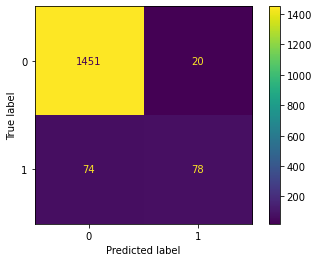

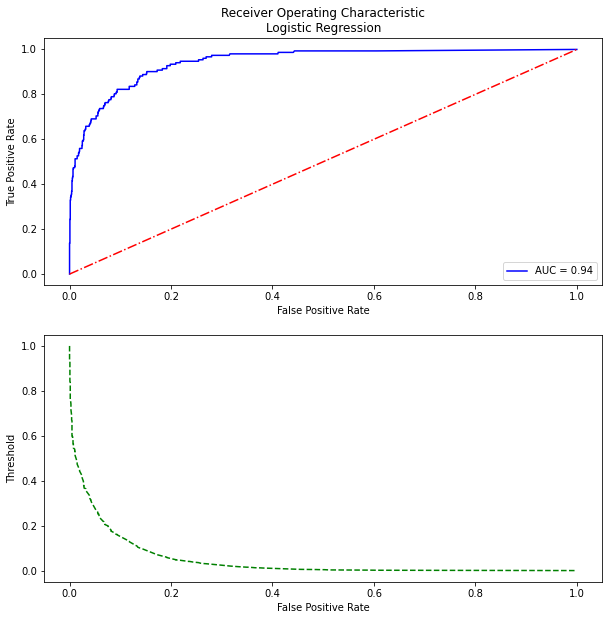

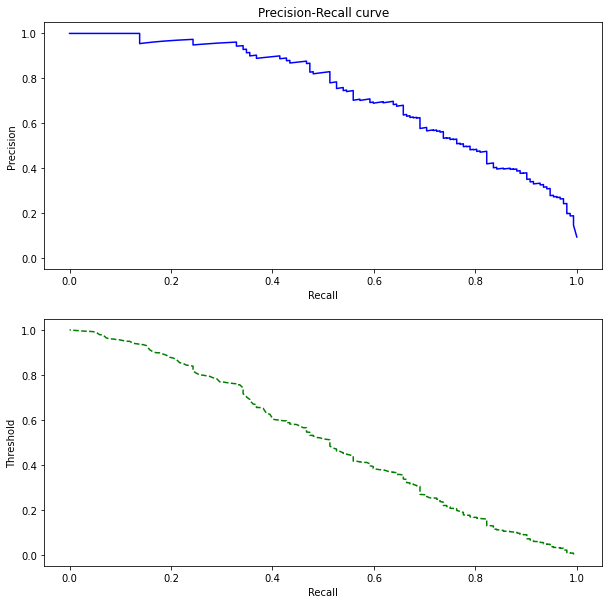

In [51]:
generate_plot(clf, X_test_std_select)

In_BeneCount                         0.081
In_weight_diagnosis_Degree           0.075
In_weight_count_Degree               0.062
In_weight_reimburse_Degree           0.060
In_weight_physician_Degree           0.038
                                      ... 
In_weight_reimburse_Closeness_dist   0.004
Out_weight_reimburse_Betweenness     0.004
Full_weight_physician_Betweenness    0.004
In_weight_diagnosis_Closeness        0.004
In_weight_procedure_Betweenness      0.004
Length: 78, dtype: float64


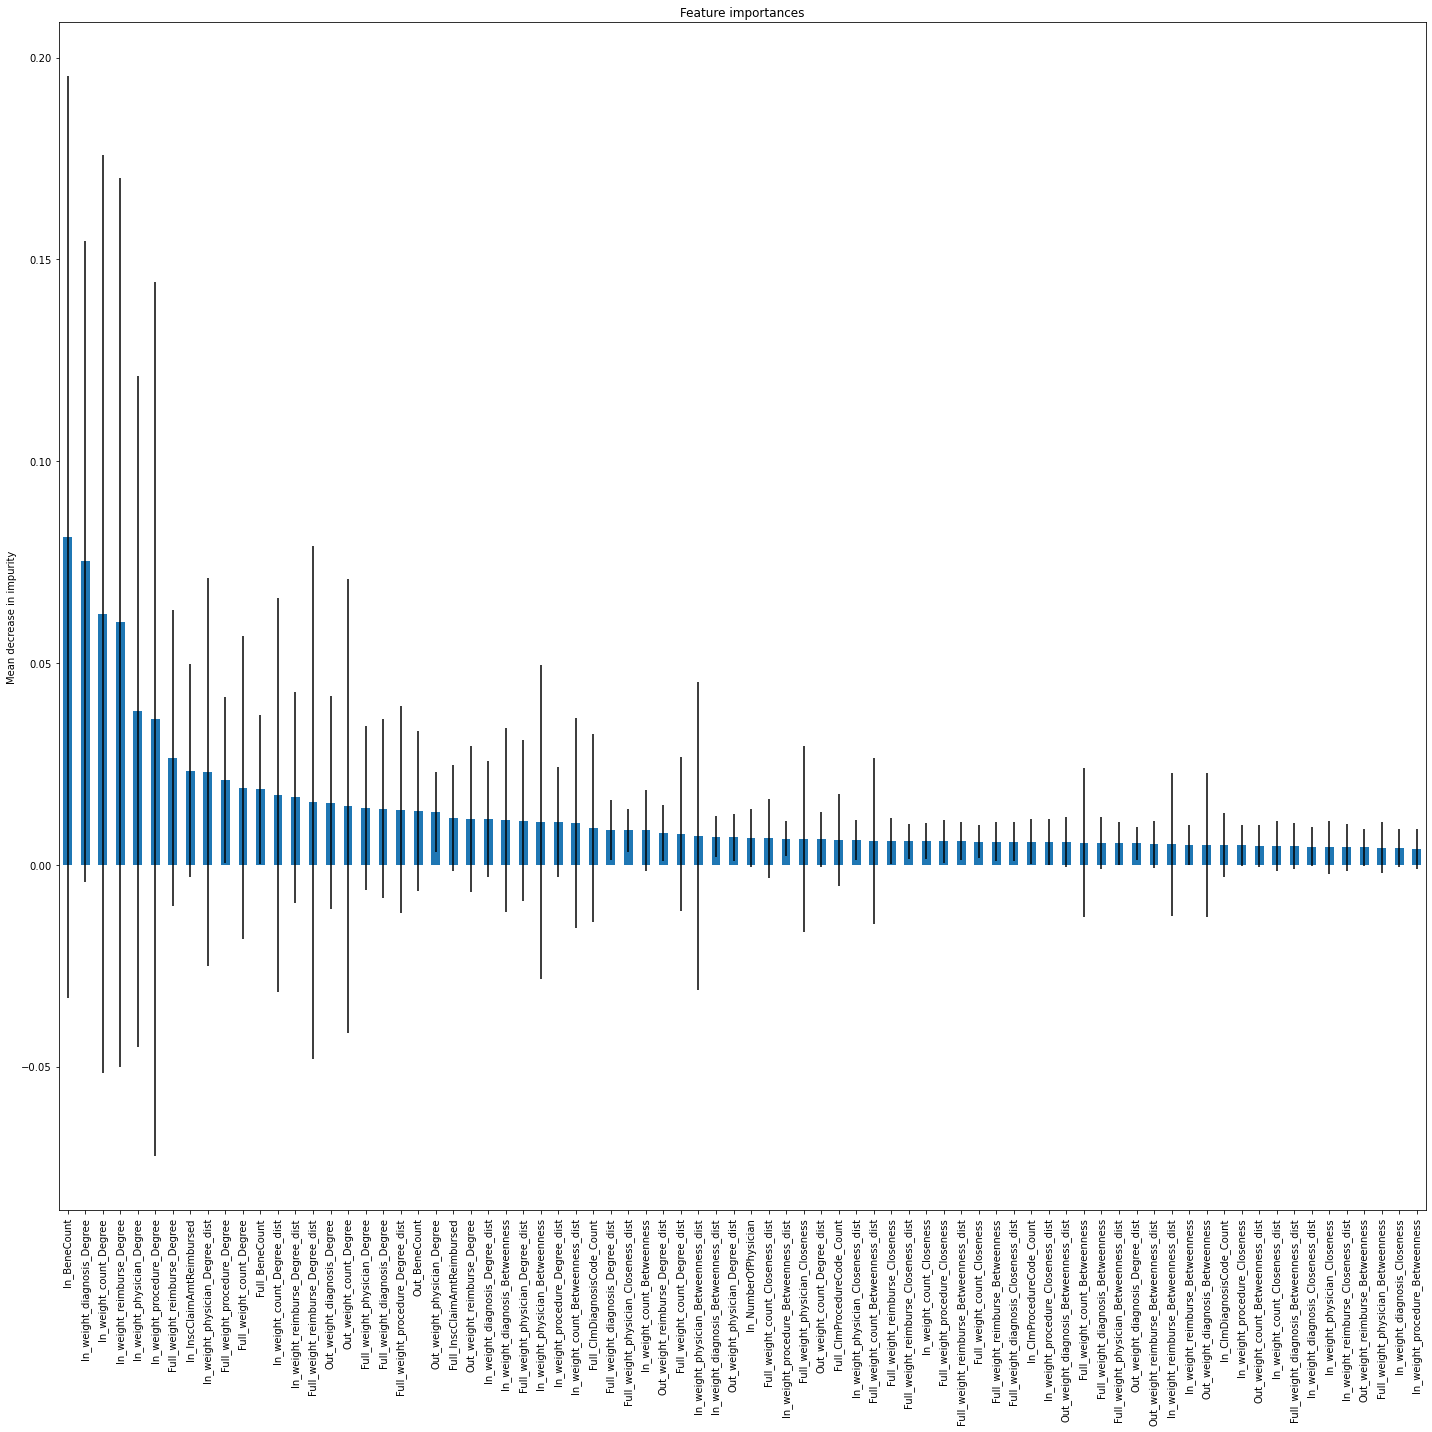

In [52]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_feature_select.columns)
forest_importances = forest_importances.sort_values(ascending=False)
print(forest_importances)

fig, ax = plt.subplots(figsize=(20,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### 1.4 XGBoost

In [53]:
import xgboost as xgb

In [54]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [55]:
from sklearn.model_selection import GridSearchCV

# Init classifier
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# Fit
_ = grid_cv.fit(X_train, y_train)

In [56]:
grid_cv.best_score_

0.9292716898723116

In [57]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.05,
 'max_depth': 7,
 'reg_lambda': 10,
 'scale_pos_weight': 1,
 'subsample': 0.8}

Auc Score:  0.9519638448602812


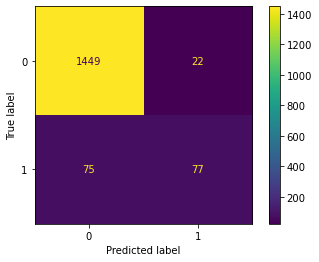

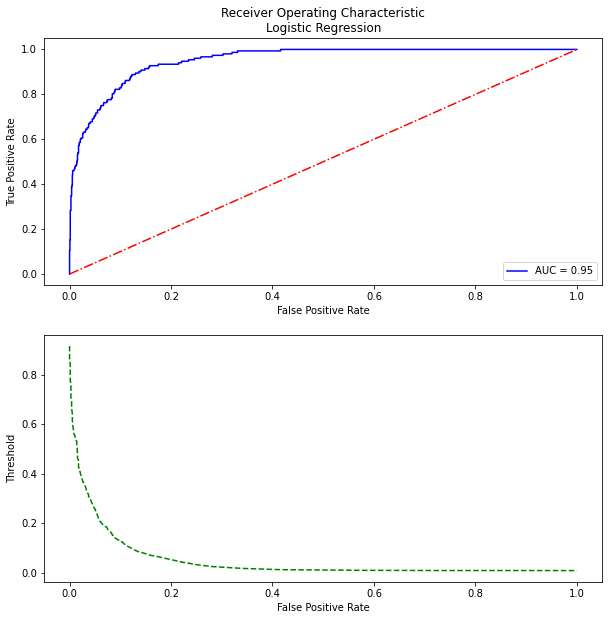

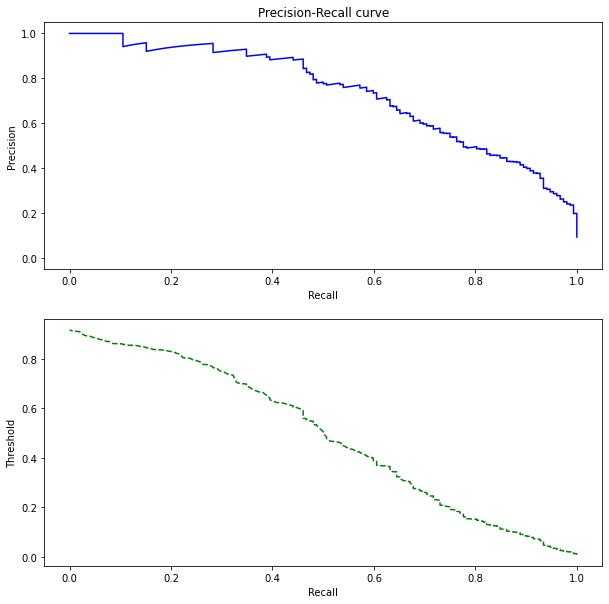

In [58]:
generate_plot(grid_cv, X_test)

#### 1.5 Catboost